## Load Data

In [27]:
import pandas as pd

In [28]:
df = pd.read_excel("../Datasets/raw/02_Used_Car_Prices.xlsx")

print("Data Shape: ", df.shape)
df.head()

Data Shape:  (6019, 12)


,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,175000.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,1250000.0
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,450000.0
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,600000.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,1774000.0


### Handling Units

In [29]:
mileage_units = df.groupby('Fuel_Type')['Mileage'].apply(lambda x: x.dropna().unique())

# Extract the unit from each mileage value
def get_mileage_unit(mileage):
    if pd.isnull(mileage):
        return None
    parts = mileage.split()
    return parts[1] if len(parts) > 1 else None

df['Mileage_Unit'] = df['Mileage'].apply(get_mileage_unit)

df.groupby('Fuel_Type')['Mileage_Unit'].unique()

Fuel_Type
CNG         [km/kg]
Diesel       [kmpl]
Electric     [None]
LPG         [km/kg]
Petrol       [kmpl]
Name: Mileage_Unit, dtype: object

`Mileage` seems to be given as `kmpl` (kilmeters per liter) for petrol/diesel and `km/kg` for CNG `Fuel_Type`. We also find that Electric Fuel Types don't seem to have a unit associated with them.

Right off the get-go, we can notice that the data still contains the units inside. We can easily remove them, but it should be noted that `Mileage `contains both `km/kg` and `kmpl` units, so we need to convert one to the other. To convert `km/kg` to `kmpl`, we multiply the `km/kg` value by **1/1.39** or around **0.72**. This is because 1`kg` of CNG is approximately equal to 1.39`liters` of petrol.

In [30]:
CNG_CONVERSION_FACTOR = 0.72

# Convert Mileage to kmpl
def convert_mileage(row):
    """Convert CNG mileage from km/kg to kmpl and extract numeric mileage."""
    if pd.isnull(row['Mileage']):
        return None
    mileage_value = float(row['Mileage'].split()[0])
    if 'km/kg' in row['Mileage'] and row['Fuel_Type'] == 'CNG':
        return round(mileage_value * CNG_CONVERSION_FACTOR, 2)
    return round(mileage_value, 2)

df['Mileage'] = df.apply(convert_mileage, axis=1)

#removing actual units
df['Engine'] = pd.to_numeric(df['Engine'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df['Power'] = pd.to_numeric(df['Power'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

df.head()

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs),Mileage_Unit
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,19.15,998.0,58.16,5.0,175000.0,km/kg
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,1250000.0,kmpl
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,450000.0,kmpl
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,600000.0,kmpl
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,1774000.0,kmpl


In [31]:
df = df.drop(["Mileage_Unit"], axis=1)
df.columns

Index(['Brand_Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price (INR Lakhs)'],
      dtype='object')

## EDA

### Stats

In [32]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

missing_df

,Missing Values,Percentage (%)
Power,143,2.375810
Seats,42,0.697790
Engine,36,0.598106
Mileage,2,0.033228


`Mileage`, `Engine`, `Power` and `Seats` have missing values. We can choose to either drop or impute data. Since the dataset is relatively small (6019 rows), we should **impute** the data to not lose the valuable data we have. We will perform this in the ML Pipeline.

In [33]:
# df['Mileage'].fillna(df['Mileage'].median(), inplace=True)
# df['Engine'].fillna(df['Engine'].median(), inplace=True)
# df['Power'].fillna(df['Power'].median(), inplace=True)

# # Mode is more commonly used for 'categorical like' numerical features, which includes number of seats.
# df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)

# df.isnull().sum()

In [34]:
df.dtypes

Brand_Model           object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price (INR Lakhs)    float64
dtype: object

In [35]:
df.describe(include='all')

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
count,6019,6019,6019.000000,6.019000e+03,6019,6019,6019,6017.000000,5983.000000,5876.000000,5977.000000,6.019000e+03
unique,1876,11,NaN,NaN,5,2,4,NaN,NaN,NaN,NaN,NaN
top,Mahindra XUV500 W8 2WD,Mumbai,NaN,NaN,Diesel,Manual,First,NaN,NaN,NaN,NaN,NaN
freq,49,790,NaN,NaN,3205,4299,4929,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2013.358199,5.873838e+04,NaN,NaN,NaN,18.068719,1621.276450,113.253050,5.278735,9.479468e+05
std,NaN,NaN,3.269742,9.126884e+04,NaN,NaN,NaN,4.510378,601.355233,53.874957,0.808840,1.118792e+06
min,NaN,NaN,1998.000000,1.710000e+02,NaN,NaN,NaN,0.000000,72.000000,34.200000,0.000000,4.400000e+04
25%,NaN,NaN,2011.000000,3.400000e+04,NaN,NaN,NaN,15.100000,1198.000000,75.000000,5.000000,3.500000e+05
50%,NaN,NaN,2014.000000,5.300000e+04,NaN,NaN,NaN,18.120000,1493.000000,97.700000,5.000000,5.640000e+05
75%,NaN,NaN,2016.000000,7.300000e+04,NaN,NaN,NaN,21.030000,1984.000000,138.100000,5.000000,9.950000e+05


One major thing we can see is a very unreasonable kilometers driven value. We will handle this by removing outliers with interquartile range.

In [36]:
categorical_cols = ['Brand_Model', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")

Brand_Model: 1876 unique values
Location: 11 unique values
Fuel_Type: 5 unique values
Transmission: 2 unique values
Owner_Type: 4 unique values


### Visuals

Let's explore individual columns to understand their distributions.

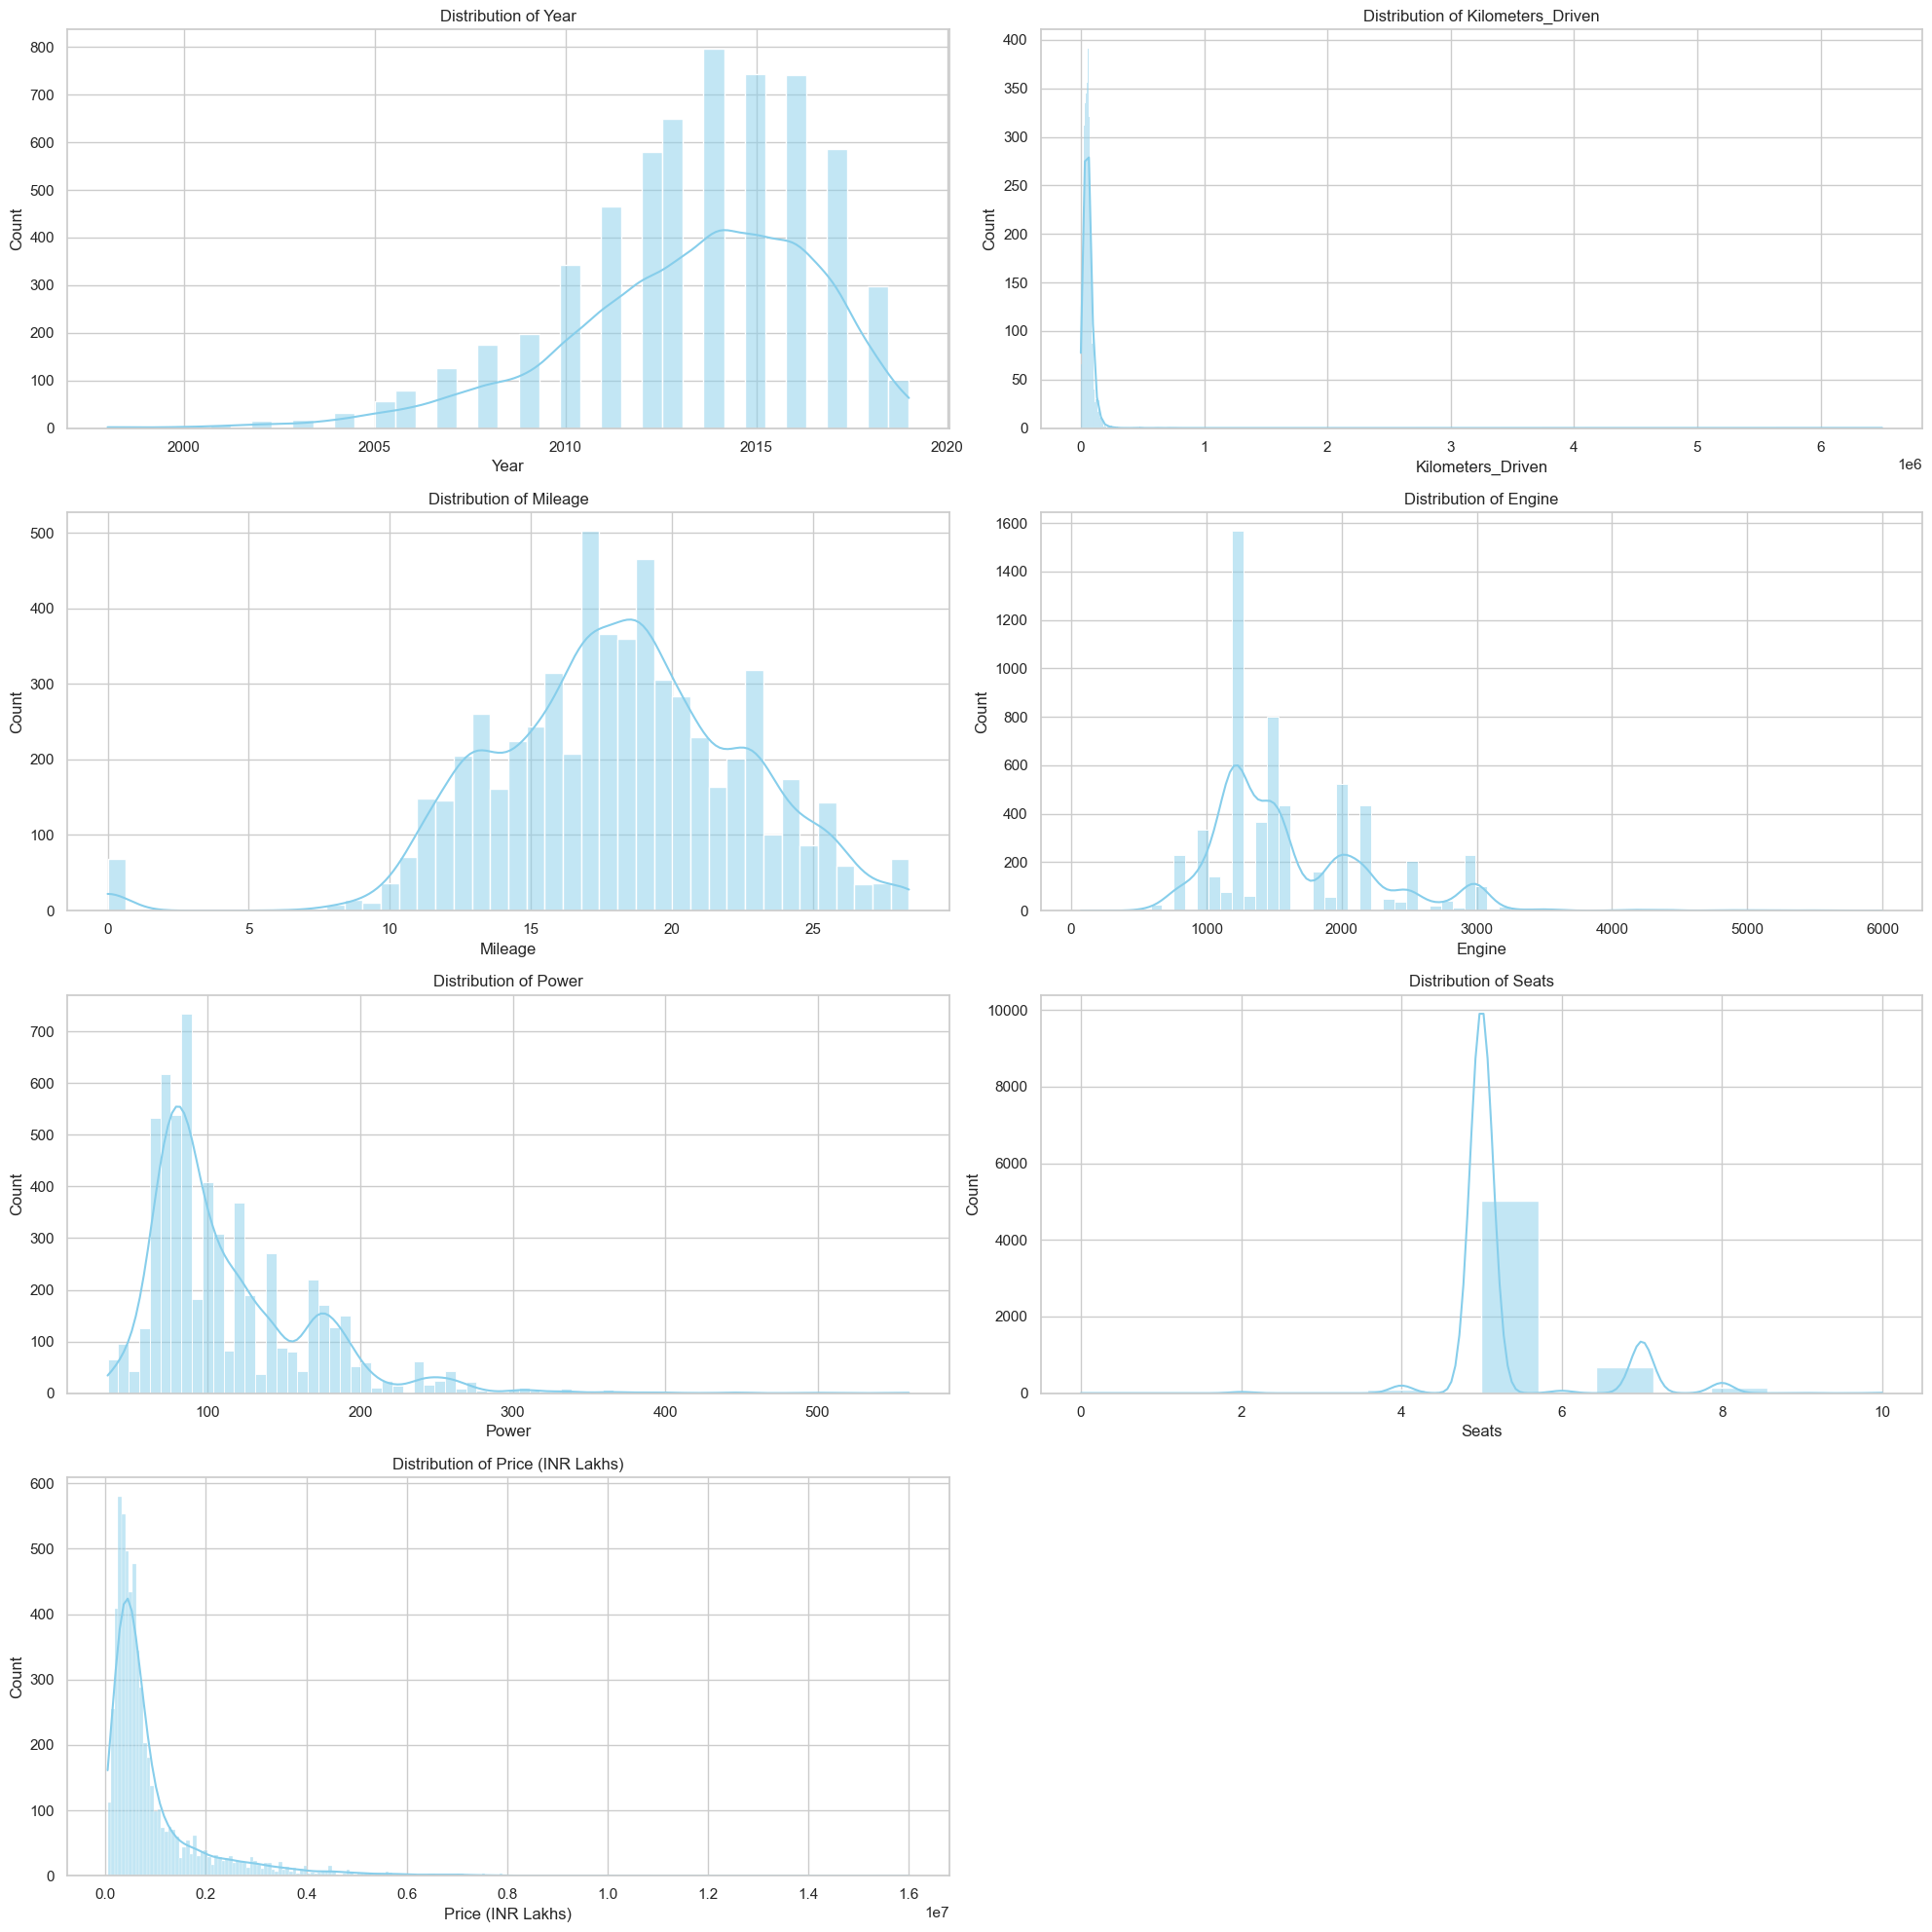

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Numerical columns to plot
numerical_cols = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price (INR Lakhs)']

plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

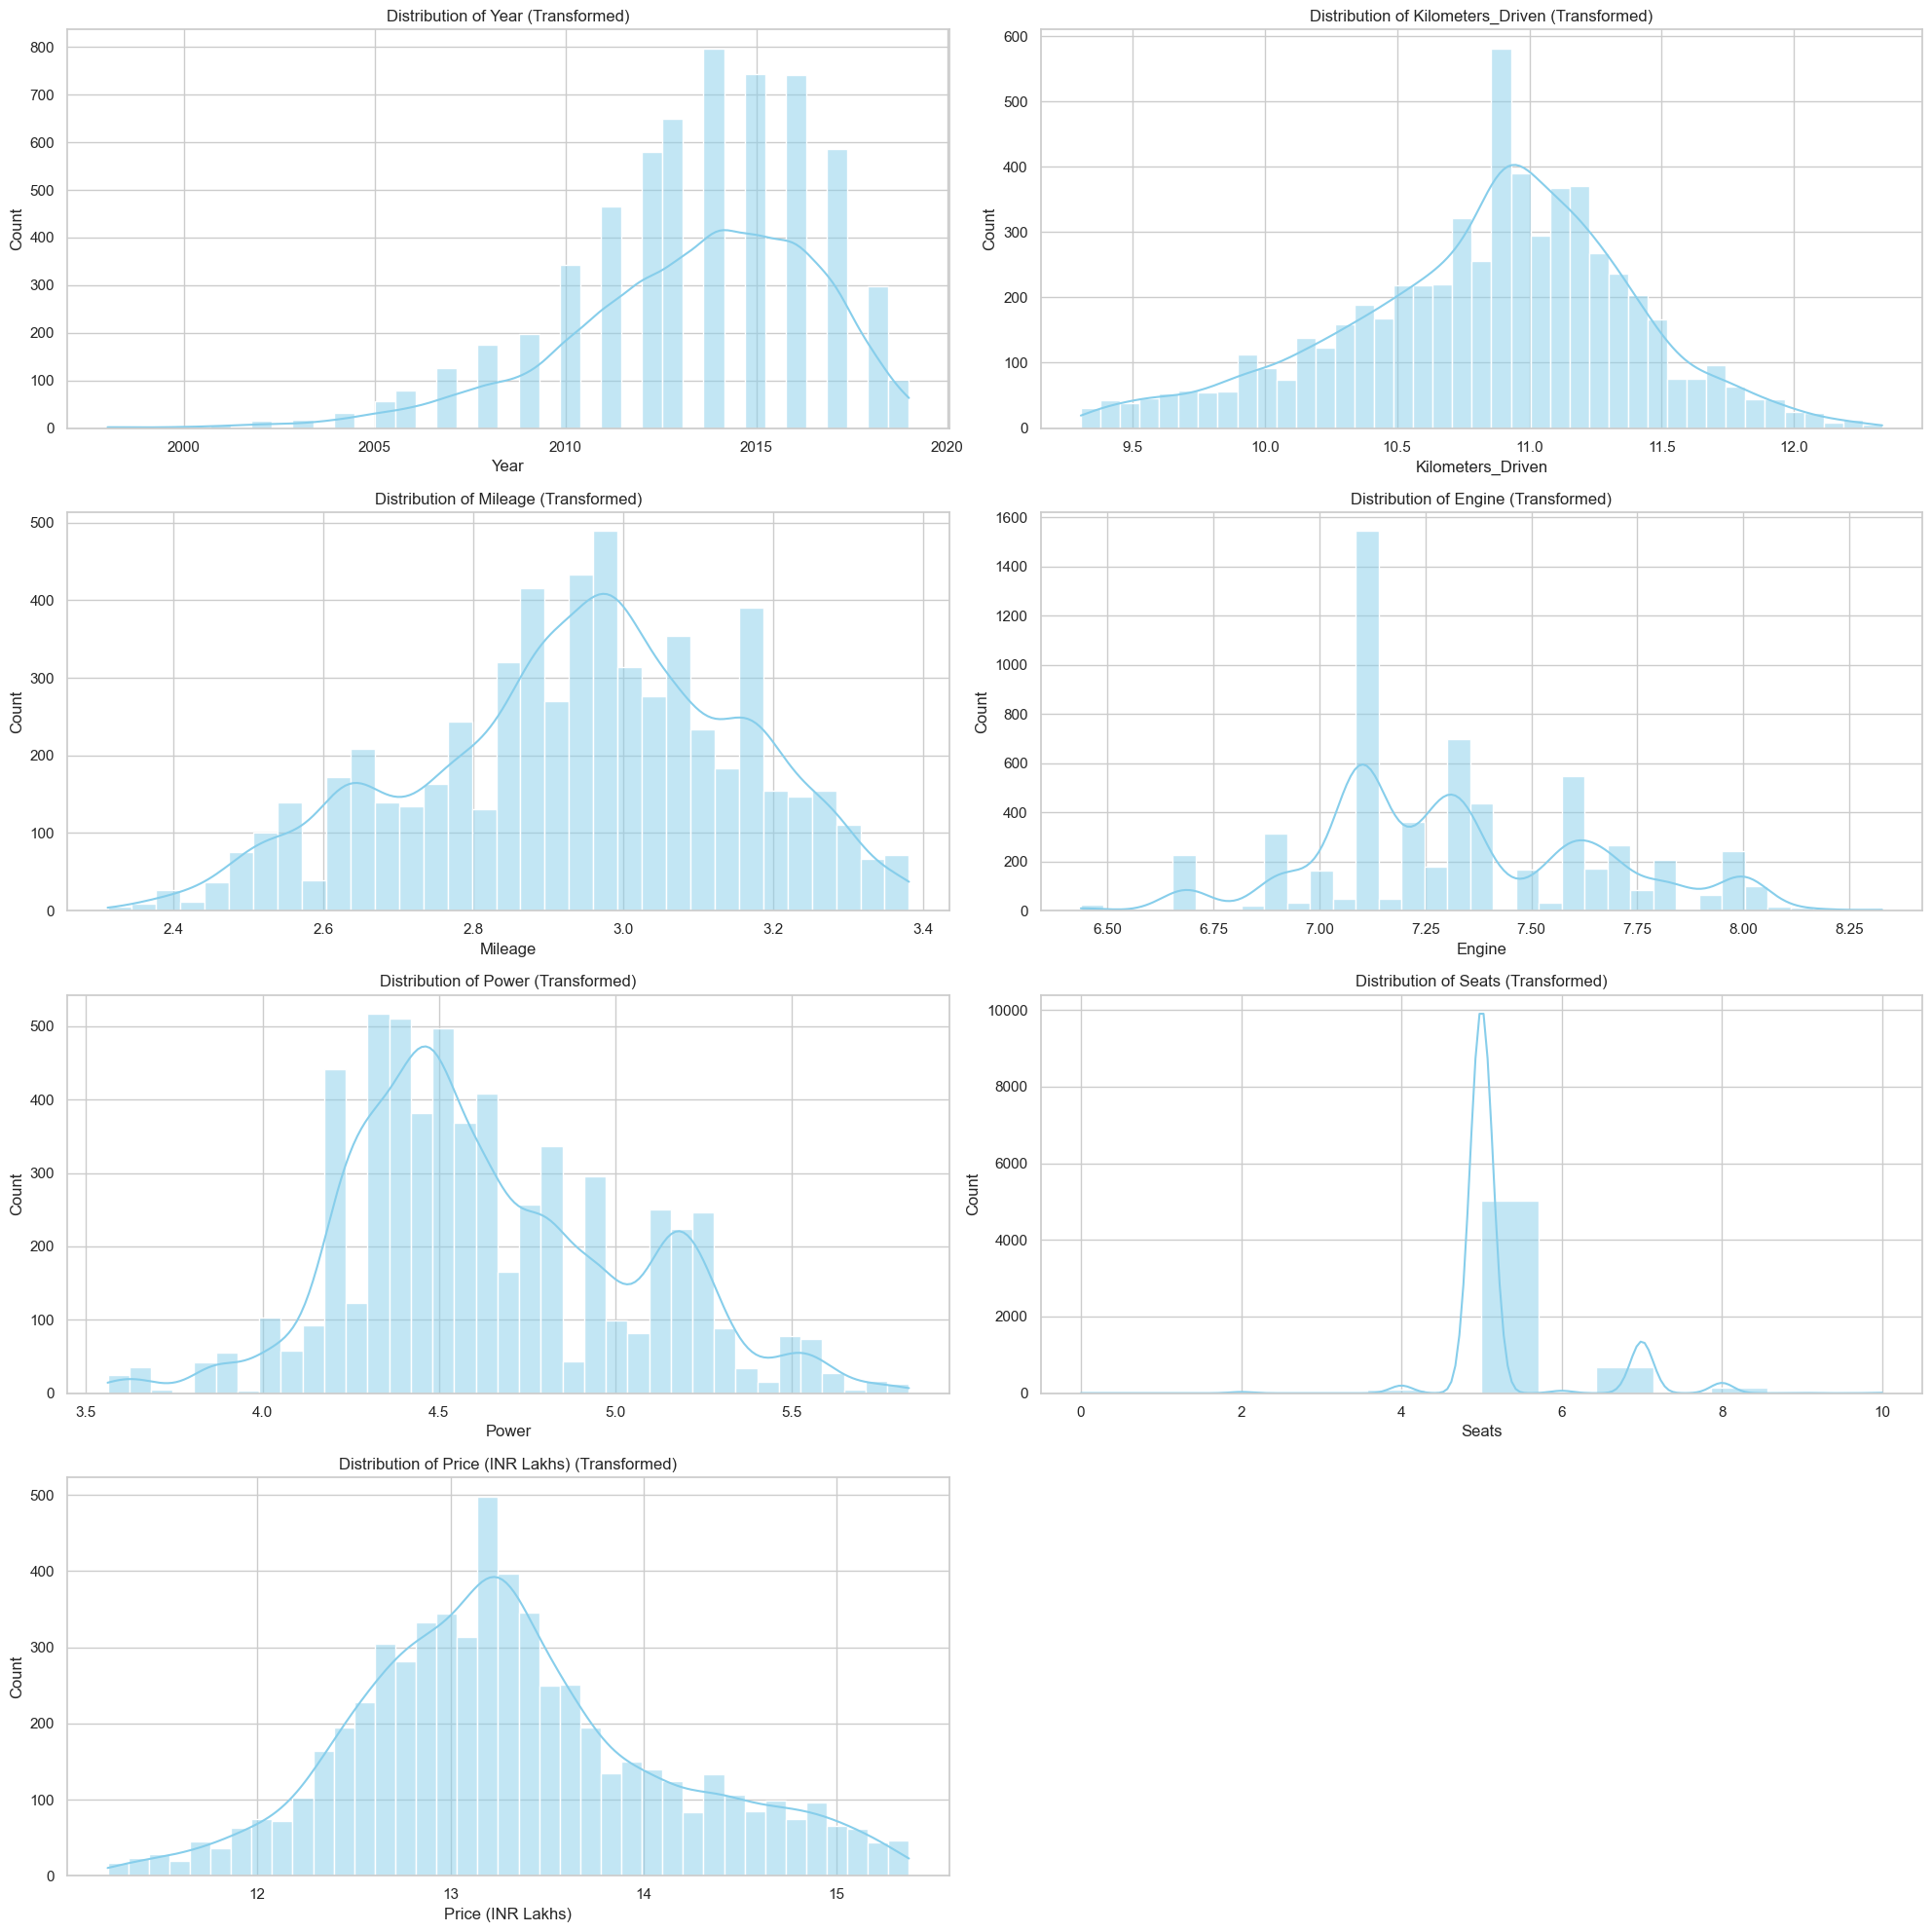

In [38]:
import numpy as np

sns.set(style="whitegrid")

skewed_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price (INR Lakhs)']

for col in skewed_cols:
    df[col] = np.log1p(df[col])

def remove_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.nan, df[col])

for col in skewed_cols:
    remove_outliers(col)
    df[col].fillna(df[col].median(), inplace=True) # Replace missing values with median

plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col} (Transformed)')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [39]:
np.log1p(175000)

12.07254696717504

In [40]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

missing_df #Check if there are any missing values

,Missing Values,Percentage (%)
Seats,42,0.69779


Now let's do the same for categorical features

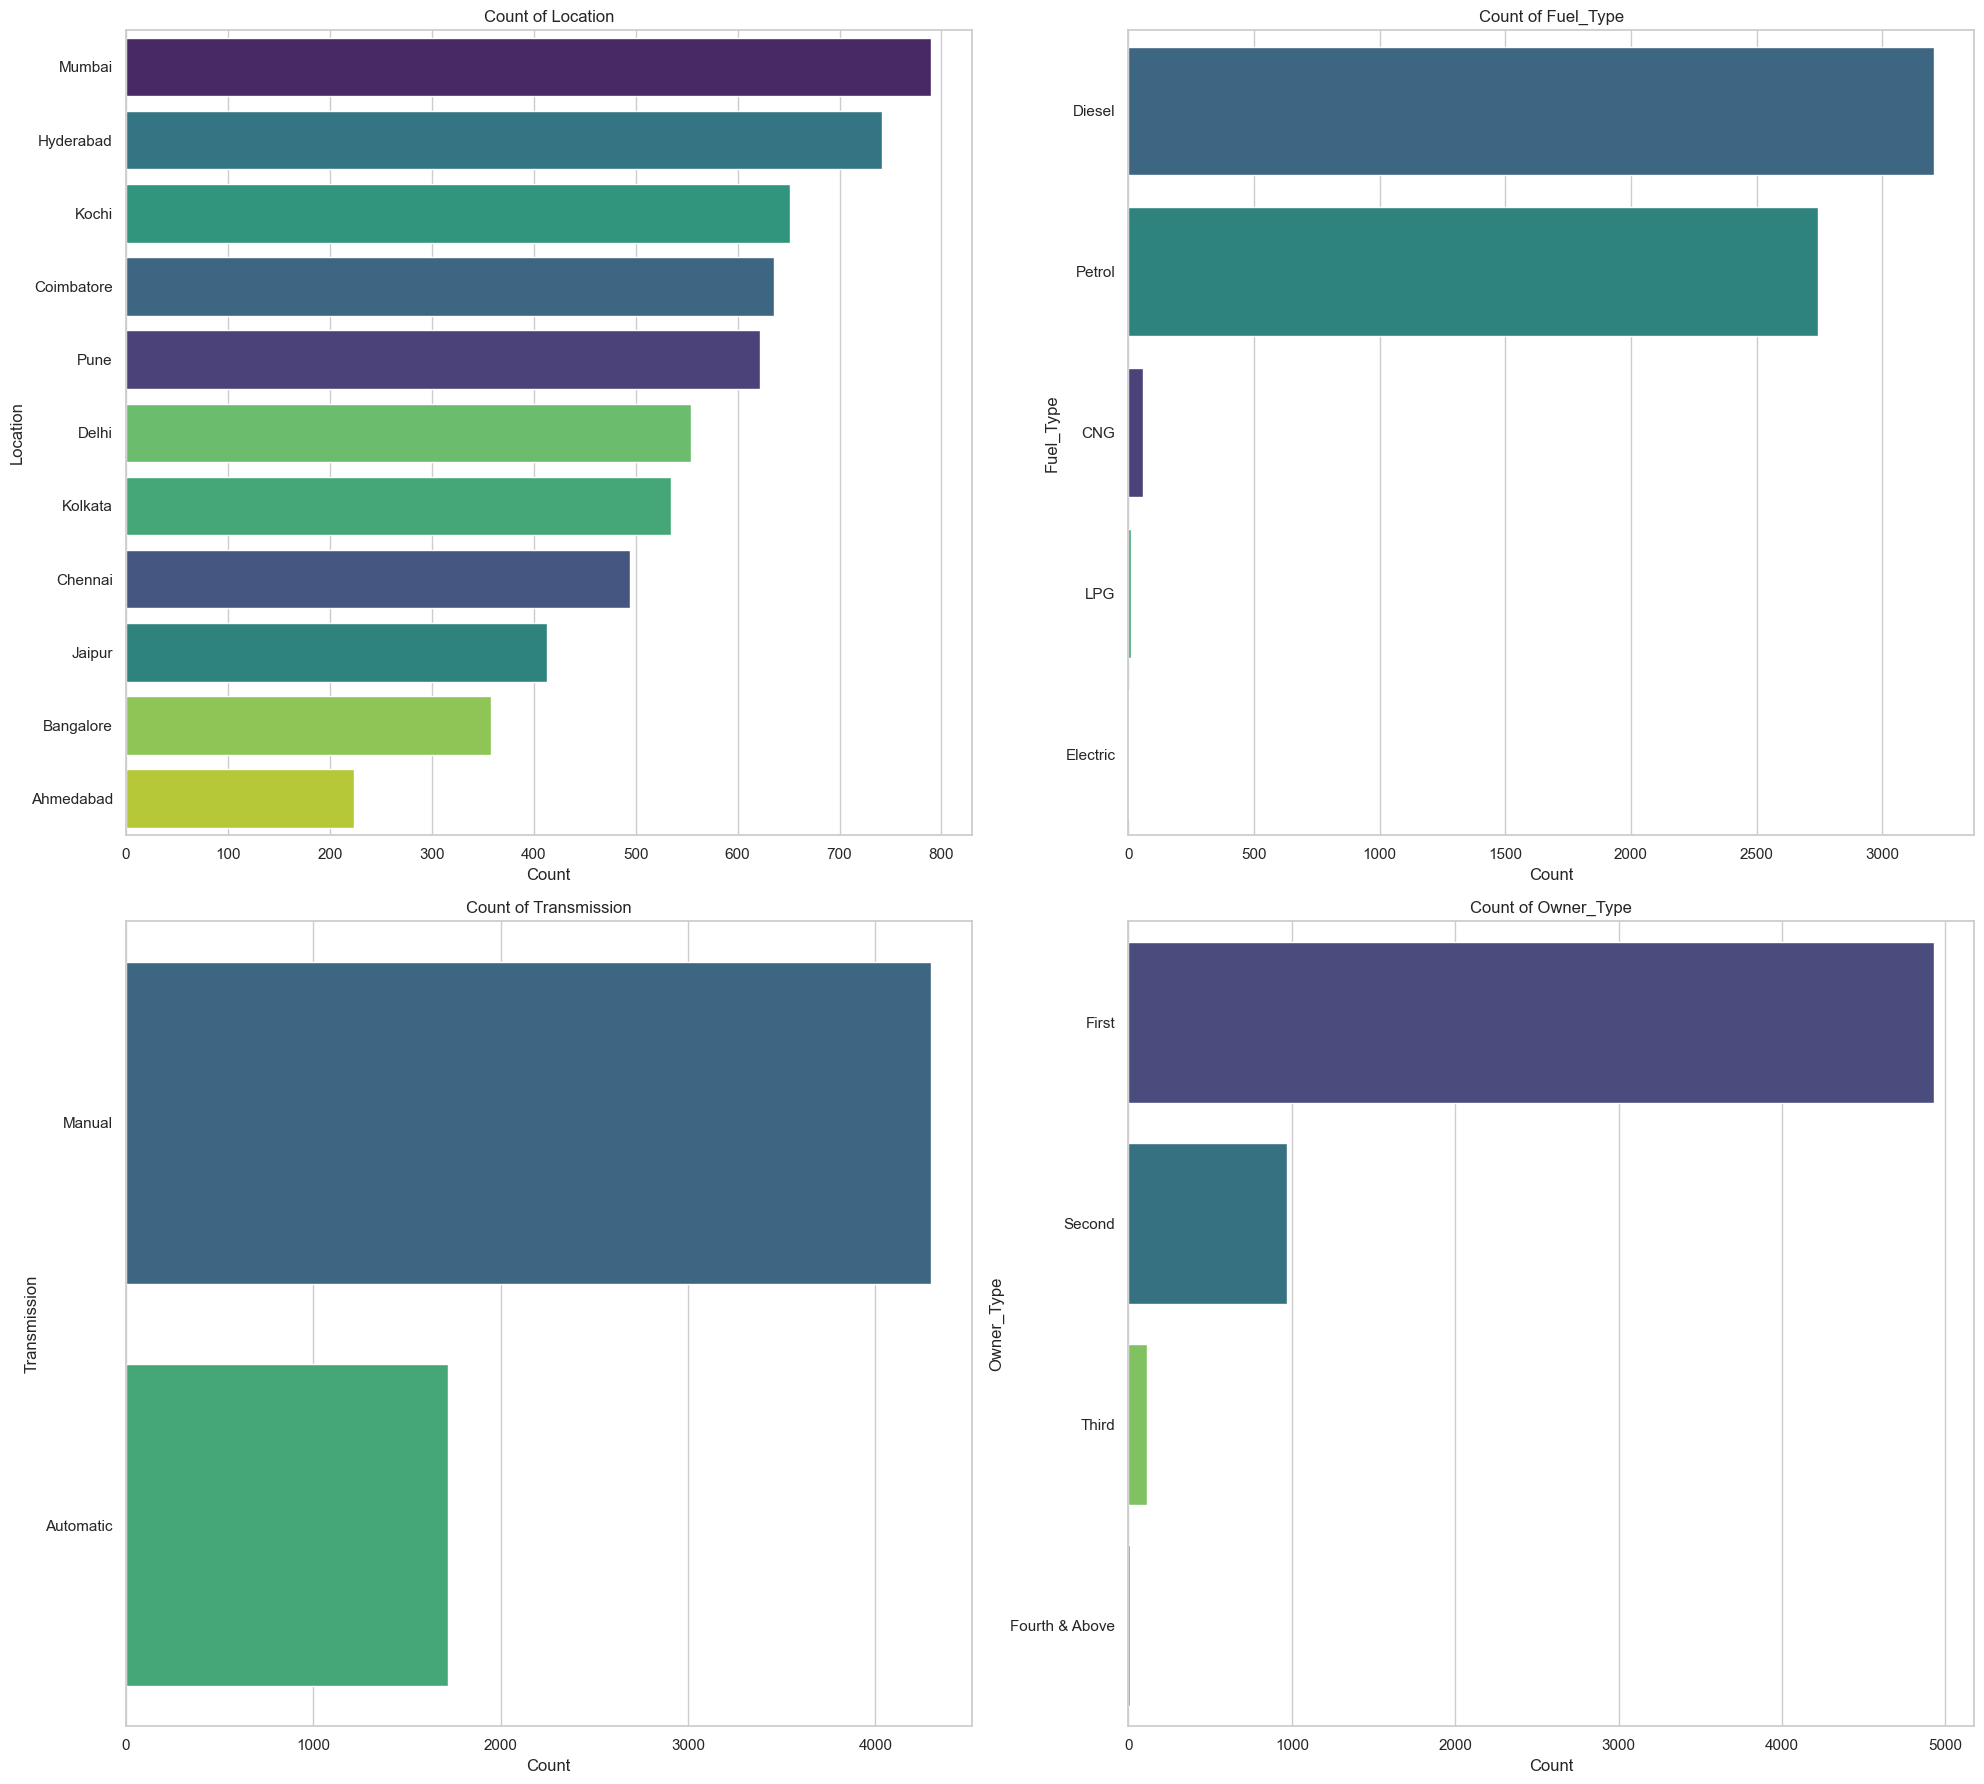

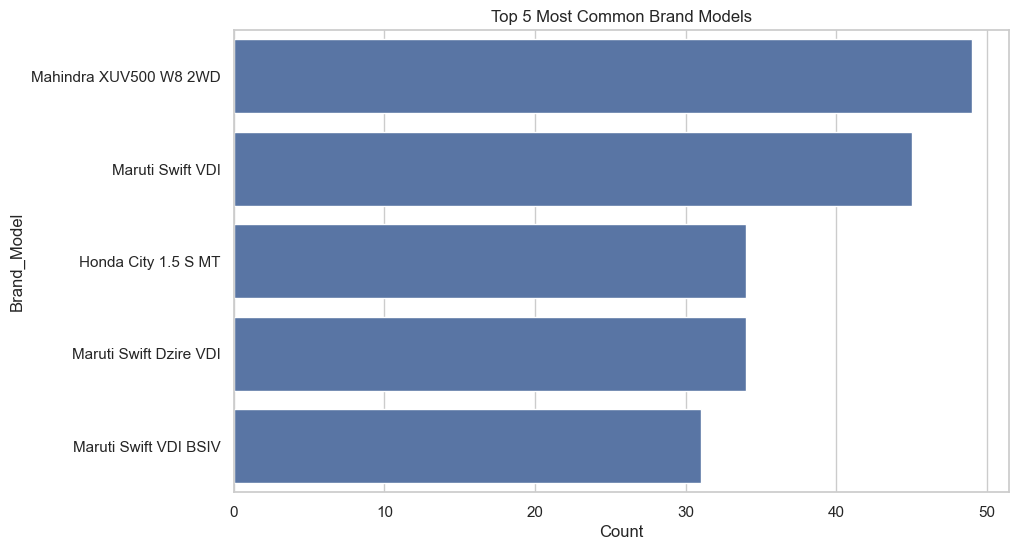

In [41]:
categorical_cols = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'] #excluding Brand_Model due to high cardinality

plt.figure(figsize=(20, 18))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, y=col, hue=col, legend=False, order=df[col].value_counts().index, palette='viridis')
    plt.title(f'Count of {col}')
    plt.xlabel('Count')

plt.tight_layout()
plt.show()

top_5_models = df['Brand_Model'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_models.values, y=top_5_models.index)
plt.title('Top 5 Most Common Brand Models')
plt.xlabel('Count')
plt.ylabel('Brand_Model')
plt.show()

Ok, it looks like for `Fuel_Type`, **Electric** cars have an occurance rate that is nearly zero, with **LPG** and **CNG** following suit. For `Owner_Type`, **Fourth & Above** have a very small sample size, and **Third* also has very few occurances.

To reduce noise, let's consider grouping the low sample size `Fuel_Type` into **'others'**, and turn **Third** and **Fourth & Above** into a combined category called **'Third & Above'**.

However, let's first to understand the relationships between price, fuel type and other features without touching these categories.

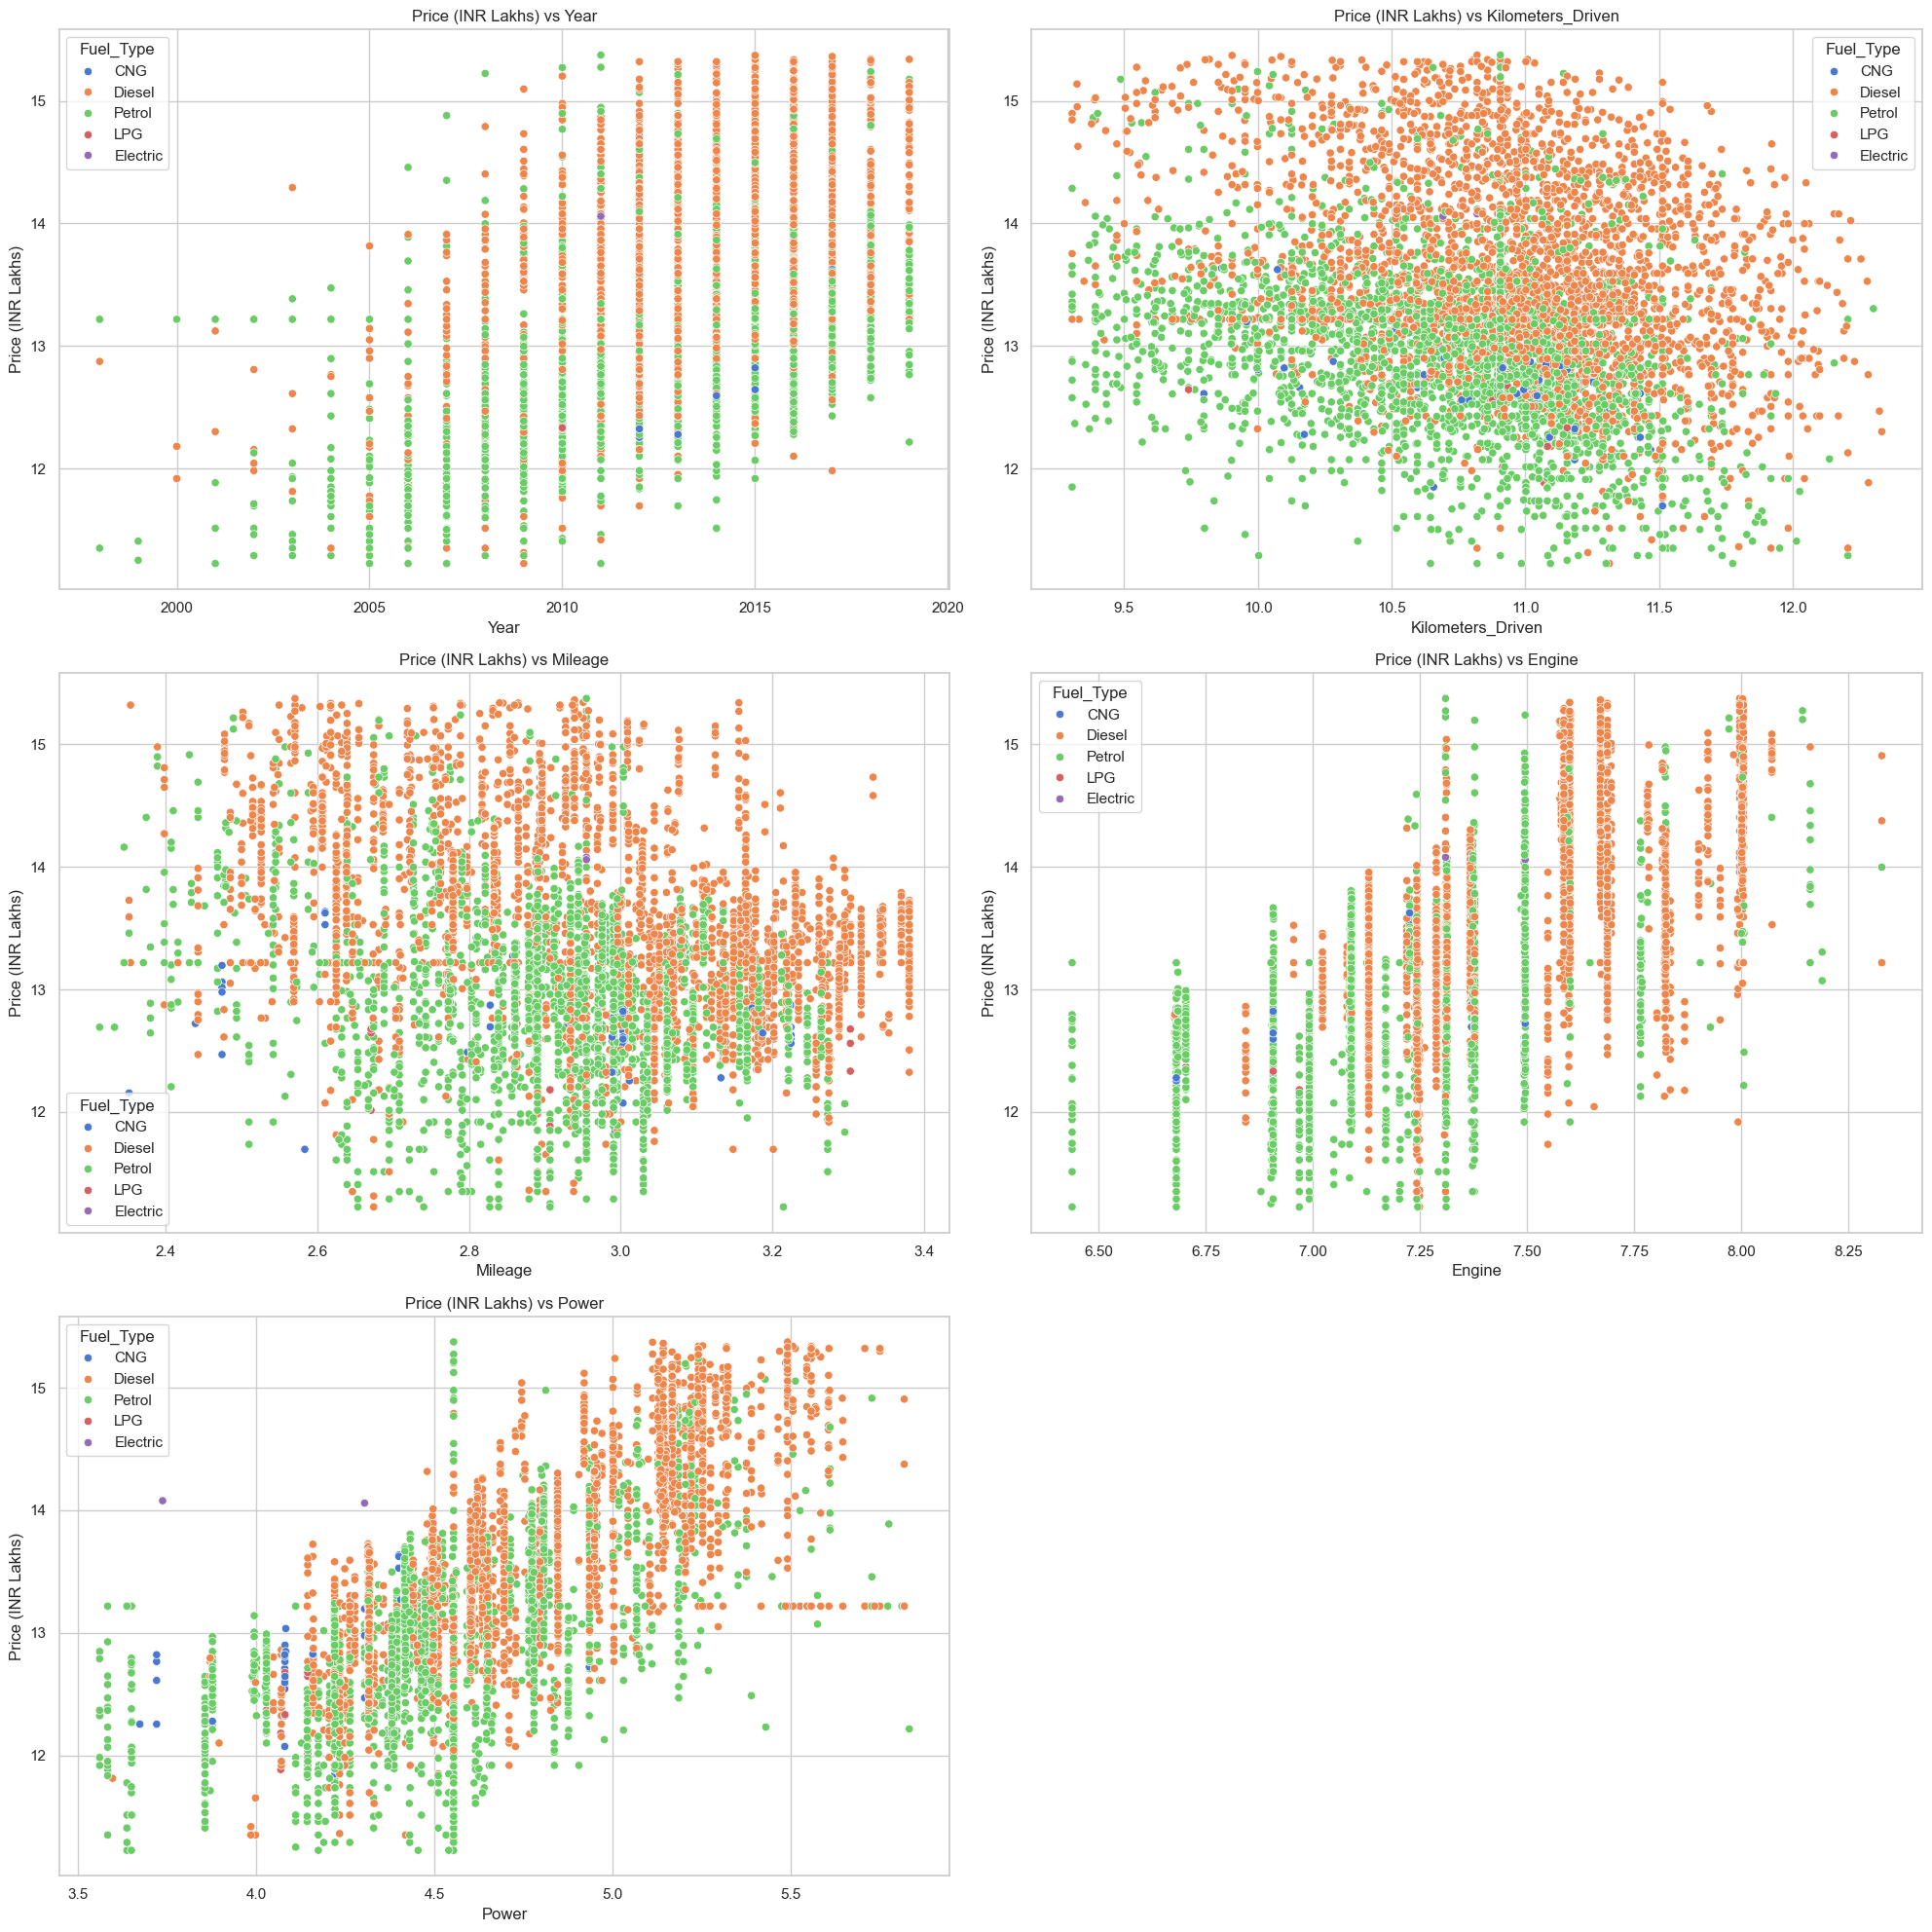

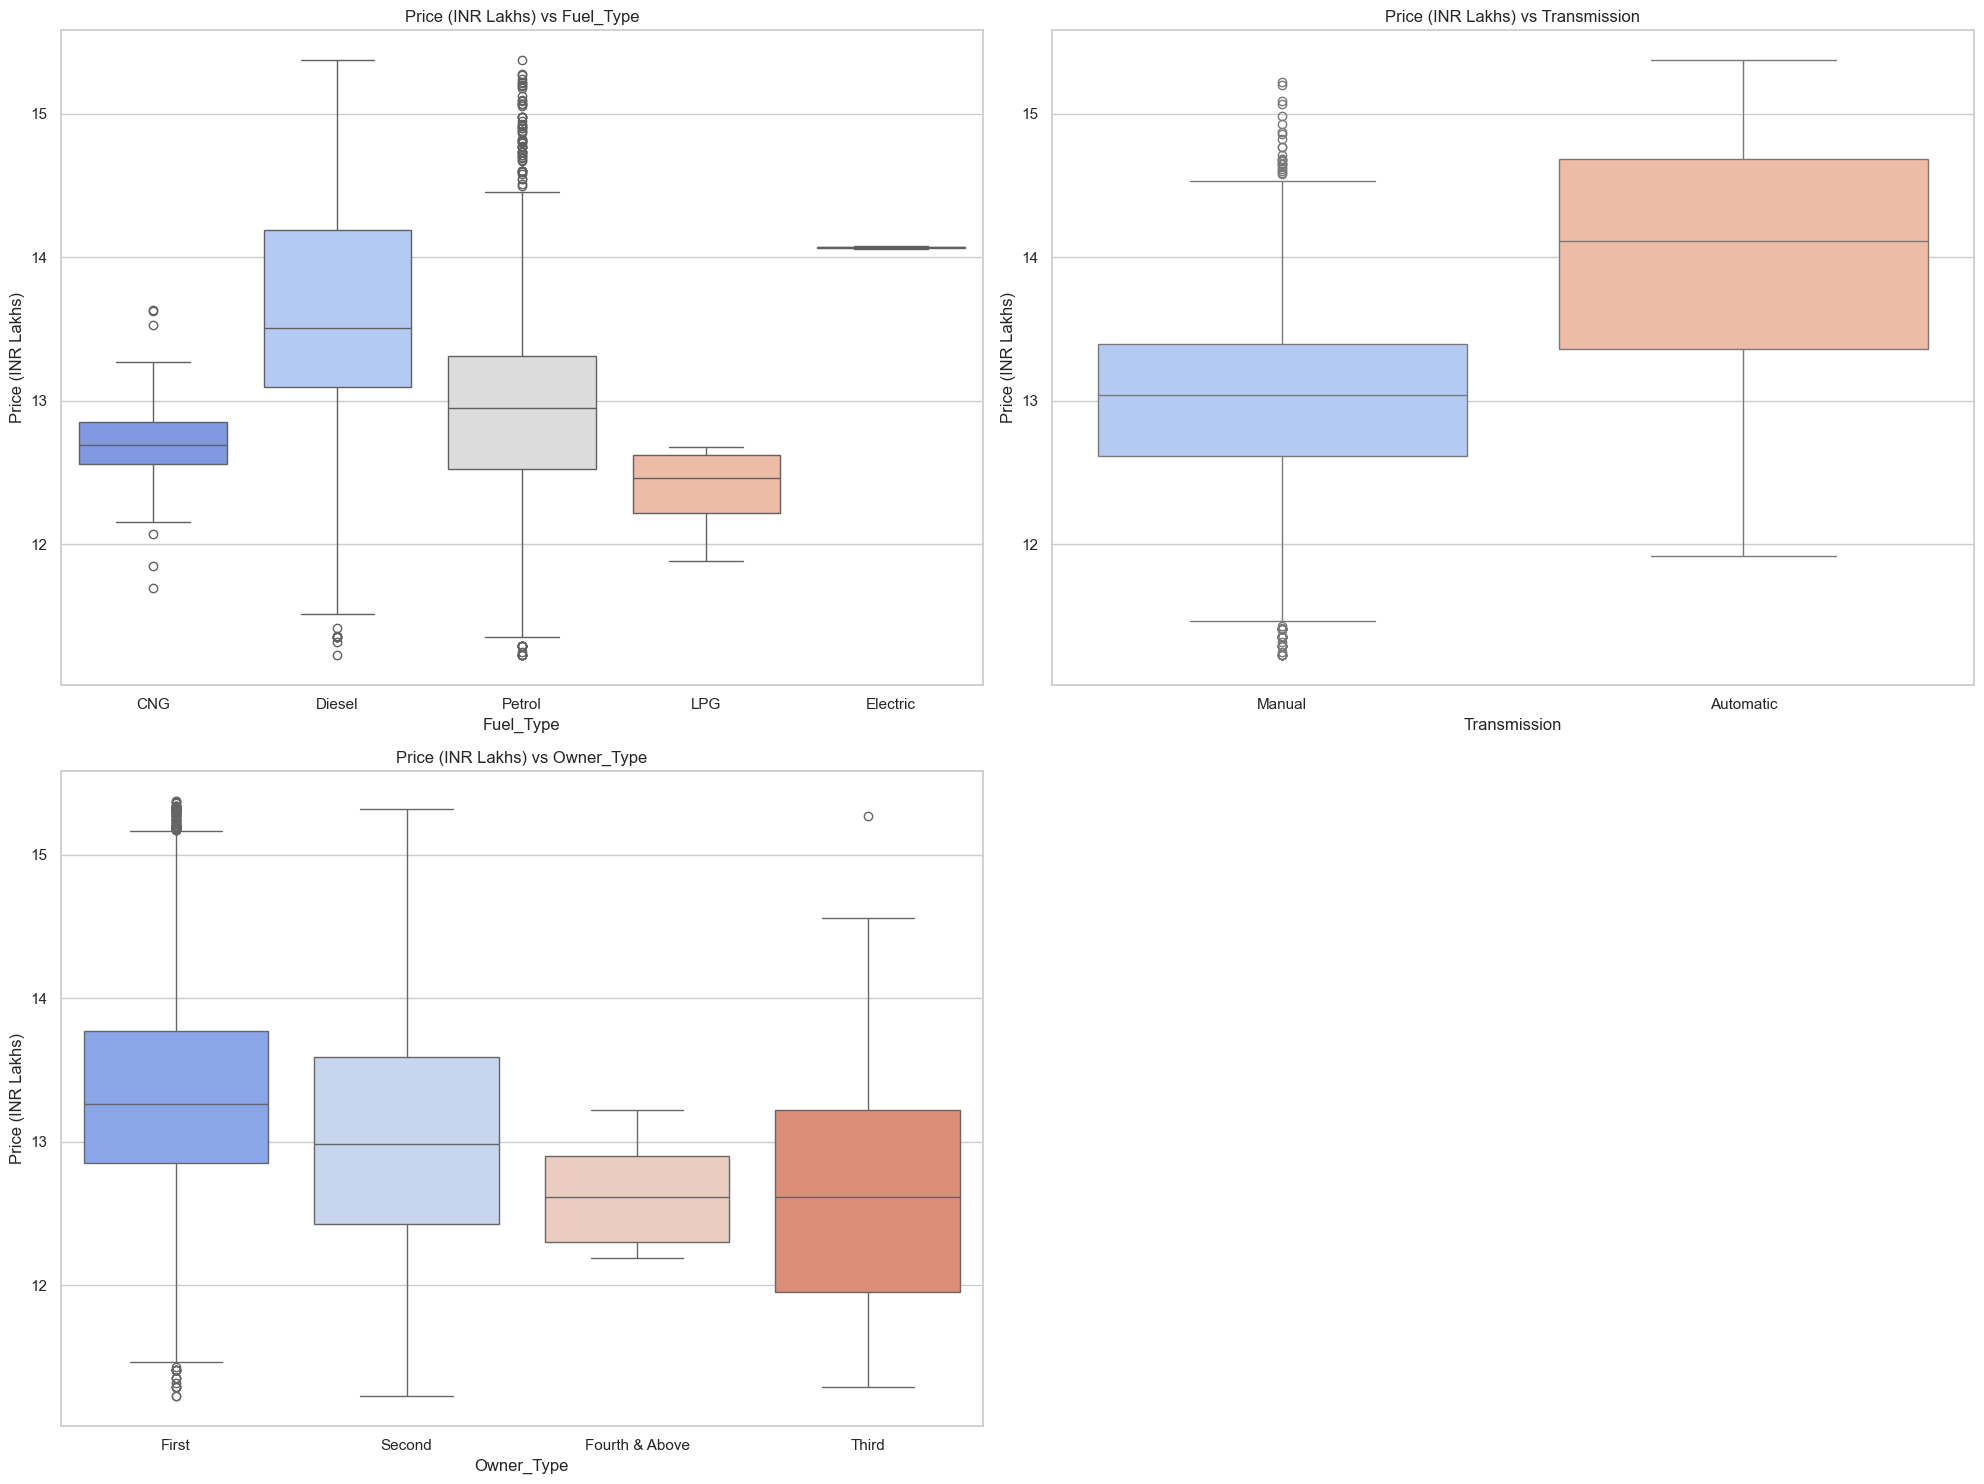

In [42]:
# Price vs Key features
plt.figure(figsize=(20, 20))
for i, col in enumerate(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power'], 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df, x=col, y='Price (INR Lakhs)', hue='Fuel_Type', palette='muted')
    plt.title(f'Price (INR Lakhs) vs {col}')

plt.tight_layout()
plt.show()

# Boxplot for categorical vs Price
plt.figure(figsize=(20, 15))
for i, col in enumerate(['Fuel_Type', 'Transmission', 'Owner_Type'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x=col, y='Price (INR Lakhs)', palette='coolwarm', hue=col)
    plt.title(f'Price (INR Lakhs) vs {col}')

plt.tight_layout()
plt.show()

In general, we can see that **Diesal** fuel types tend to go for higher prices.

We can see from this that price generally increases over years, but maximum prices have stalled in recent years from **2011** to **2019**, while the minimum prices are increasing. Values drop for kilometers driven at around 11.5`km`, and `Miileage` also causes prices to drop at 3.2`km/kg`. Moreover, the higher the `Engine` cc, the higher the prices are. Finally, higher `Power` correlate with higher prices as well.

Looking at categorical values, it turns out **Electric** cars cost the most on average, though there is neary no data on it, followed by Diesel, Petrol, CNG and finally Petrol Fuel type cars. Regarding `Transmission`, **Automatic** cars cost more than **Manual** cars. 

Finally, the price initially drops with the increase in owners who have used the car... However, **Fourth & Above** unexpectedly costs slightly higher than **Third** `Owner_Type` cars. This could be due to the reduced influence on the feature after 3 or more owners have used the car, as the car information could have been presented to them as **only either First**, **Second** or **Third** hand, *which could hinder results*.

#### Verdict for data grouping

Given the minimal data for **Electric** cars and the price similarity between **LPG** and **CNG** cars, we can safely group them under a single category, **'Other'**. Similarly, the price difference between **Third** and **Fourth & Above** `Owner_Type` cars is insignificant, making it reasonable to combine them into a **'Third & Above'** category.

In [43]:
df["Owner_Type"] = df["Owner_Type"].replace({"Third": "Third & Above", "Fourth & Above": "Third & Above"})
df["Owner_Type"].value_counts()

Owner_Type
First            4929
Second            968
Third & Above     122
Name: count, dtype: int64

In [44]:
low_fuel_types = ['LPG', 'CNG', 'Electric']

df['Fuel_Type'] = df['Fuel_Type'].replace(low_fuel_types, 'Other')
df["Fuel_Type"].value_counts()

Fuel_Type
Diesel    3205
Petrol    2746
Other       68
Name: count, dtype: int64

Let's take a look at the visuals again!

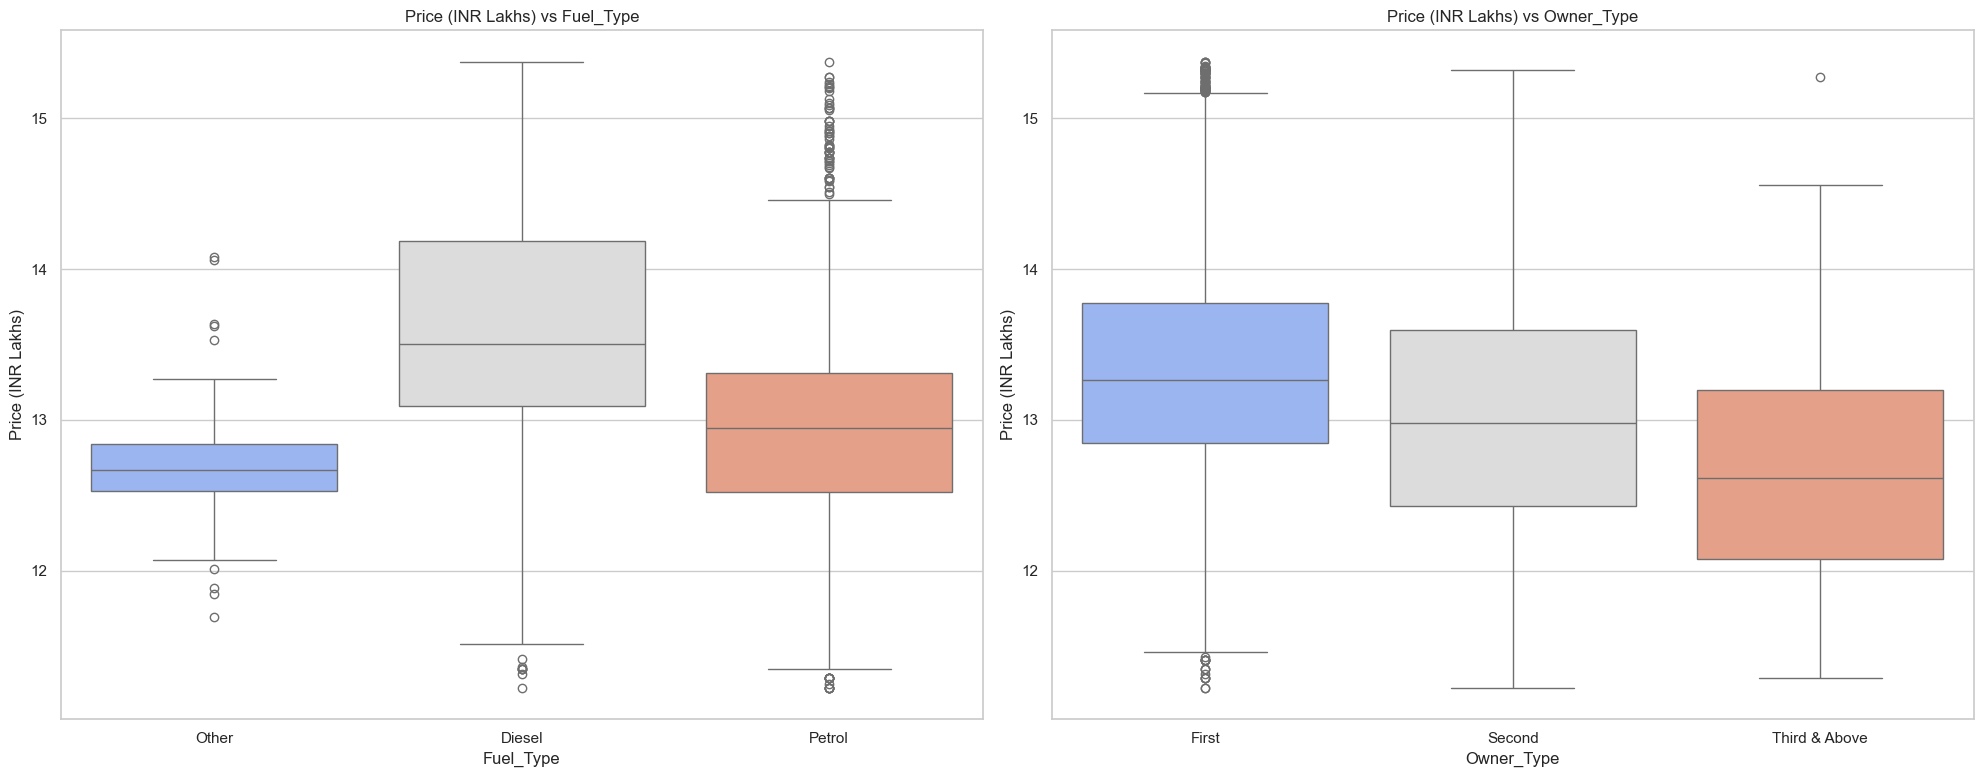

In [45]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(['Fuel_Type', 'Owner_Type'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x=col, y='Price (INR Lakhs)', palette='coolwarm', hue=col)
    plt.title(f'Price (INR Lakhs) vs {col}')

plt.tight_layout()
plt.show()

We can now update our findings to conclude that for `Fuel_Type`, **Diesal** costs the most, **Petrol** second, and **Other** fuel types come last. 

For `Owner_Type`, there is an ordinal relationship, where **First** hand cars cost the most, followed by **Second** hand, then **Third & Above**.

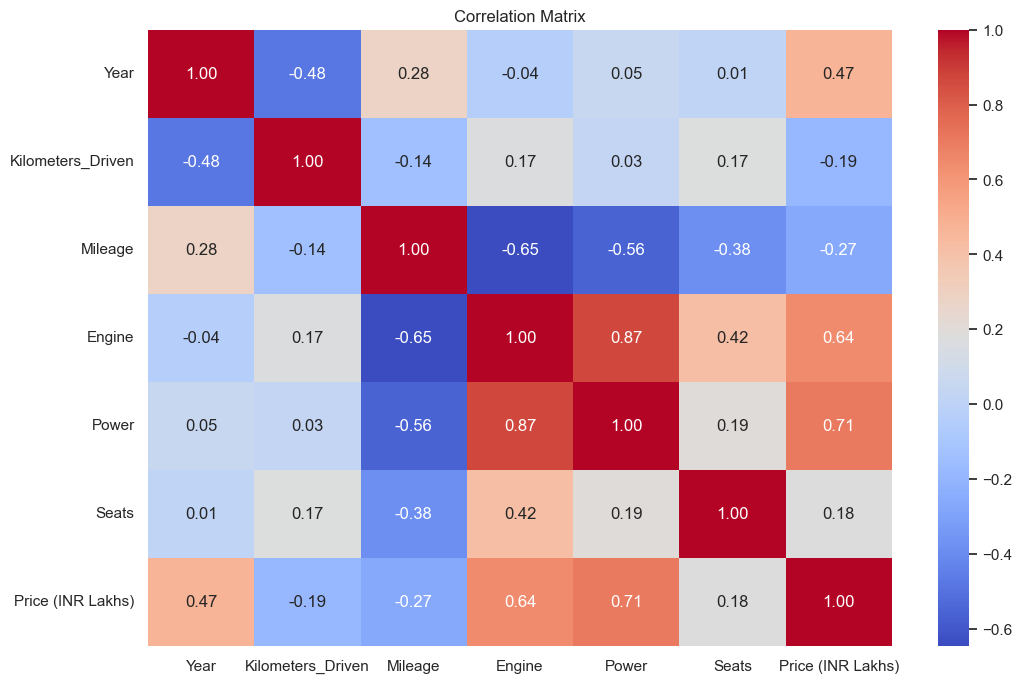

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Amongst all the features, `Power` and `Engine` have the highest correlation at **0.87**. Since the target variable is `Price(INR Lakhs)`, this would cause multicollinearity issues. To correct this, we can remove either of these features. Since `Power` has a stronger link to price, we should keep it and drop `Engine`.

In [47]:
df = df.drop(["Engine"], axis = 1)
df.columns

Index(['Brand_Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Power', 'Seats',
       'Price (INR Lakhs)'],
      dtype='object')

### Encoding Categorical Features

1. For `Brand_Model`, there are 1876 unique values. Hence, we should avoid one hot encoding for this feature, as it would make the dataset highly dimensional. Instead, we will use **frequency encoding** to capture the popularity of each brand. *(Upon consideration, **Target encoding** was replaced as it can cause target leakage, causing the model to learn from the target variable rather than the independent feature. It basically replaces each brand model with its average car price.)*
2. We should **one hot encode** `Location`, `Fuel_Type`, and `Tramsmission`. (**Done in PyCaret File**)
3. **Label encoding** would make sense for `Owner_Type`, as the values are ordinal as established earlier.

In [48]:
brand_model_counts = df['Brand_Model'].value_counts()
df['Brand_Model_Encoded'] = df['Brand_Model'].map(brand_model_counts)

# Save map to csv
brand_model_df = brand_model_counts.reset_index()
brand_model_df.columns = ['Brand_Model', 'Frequency']

# Export to CSV
brand_model_df.to_csv('../datasets/brand_model_frequency.csv', index=False)

df.drop('Brand_Model', axis=1, inplace=True)

df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Price (INR Lakhs),Brand_Model_Encoded
0,Mumbai,2010,11.184435,Other,Manual,First,3.003204,4.080246,5.0,12.072547,18
1,Pune,2015,10.621352,Diesel,Manual,First,3.028683,4.845761,5.0,14.038655,12
2,Chennai,2011,10.736418,Petrol,Manual,First,2.954910,4.496471,5.0,13.017005,4
3,Chennai,2012,11.373675,Diesel,Manual,First,3.080533,4.497139,7.0,13.304687,25
4,Coimbatore,2013,10.613271,Diesel,Automatic,Second,2.785011,4.954418,5.0,14.388748,7


In [49]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Owner_Type'] = le.fit_transform(df['Owner_Type'])

df['Owner_Type'].unique() #0 is First hand, 1 is second hand, 2 is Third & Above

array([0, 1, 2])

In [50]:
df

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Price (INR Lakhs),Brand_Model_Encoded
0,Mumbai,2010,11.184435,Other,Manual,0,3.003204,4.080246,5.0,12.072547,18
1,Pune,2015,10.621352,Diesel,Manual,0,3.028683,4.845761,5.0,14.038655,12
2,Chennai,2011,10.736418,Petrol,Manual,0,2.954910,4.496471,5.0,13.017005,4
3,Chennai,2012,11.373675,Diesel,Manual,0,3.080533,4.497139,7.0,13.304687,25
4,Coimbatore,2013,10.613271,Diesel,Automatic,1,2.785011,4.954418,5.0,14.388748,7
...,...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,2014,10.217057,Diesel,Manual,0,3.380995,4.317488,5.0,13.071072,45
6015,Jaipur,2015,11.512935,Diesel,Manual,0,3.234749,4.276666,5.0,12.899222,8
6016,Jaipur,2012,10.915107,Diesel,Manual,1,2.708050,4.727388,8.0,12.577640,1
6017,Kolkata,2013,10.736418,Petrol,Manual,0,2.990720,4.220977,5.0,12.487489,23


### Feature Importance

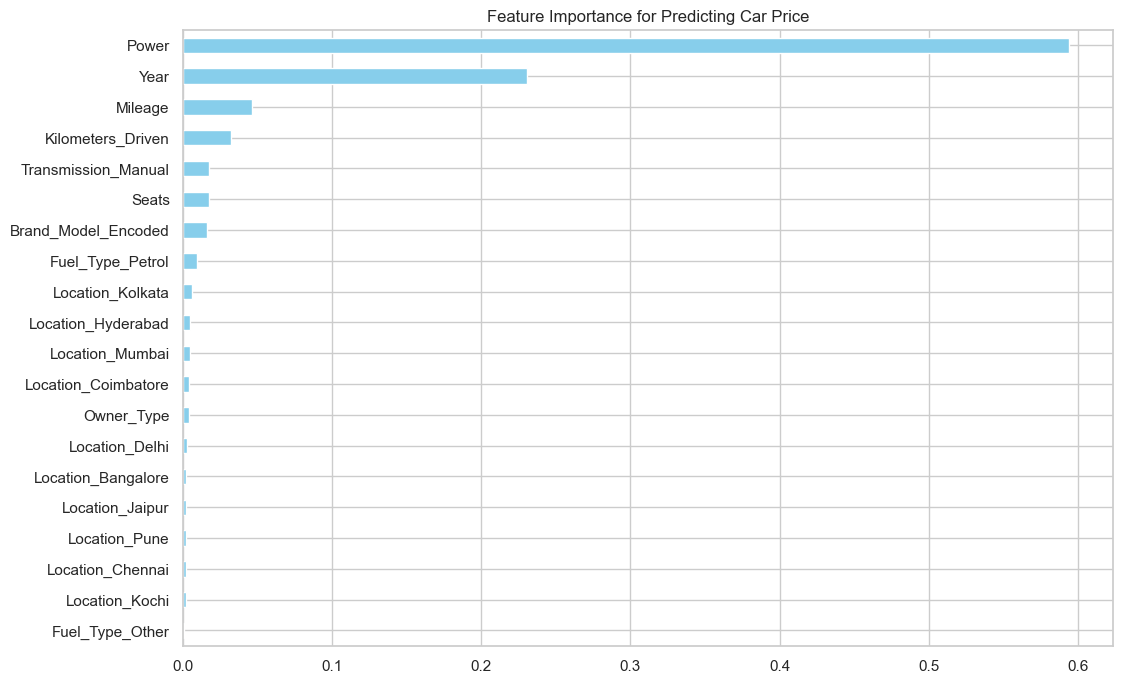

In [51]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=['Price (INR Lakhs)'])
X = pd.get_dummies(X, drop_first=True)
y = df['Price (INR Lakhs)']

model = RandomForestRegressor(random_state=0)
model.fit(X, y)

plt.figure(figsize=(12, 8))
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Feature Importance for Predicting Car Price')
plt.show()

`Power` holds the greatest feature significance, followed by `Year`, then `Mileage`. Other features are not as important, but hold some value over the prediction.

## Save Data

In [52]:
from sklearn.model_selection import train_test_split

train_df, unseen_df = train_test_split(df, test_size=0.1, random_state=123)

train_df.to_excel("../datasets/processed/processed_train_car_data.xlsx", index=False)
unseen_df.to_excel("../datasets/processed/processed_unseen_car_data.xlsx", index=False)

In Summary, for model deployment, I will have to manually ensure that for categorical input fields, information is automatically encoded. I will also have to log1p `Kilometers_Driven`, `Mileage` and `Power`. Additionally, some category values were changed to other, so they must be handled as well.